### Orbit Calculation around barycenter with Numpy

This notebook represents latest version of this class.
It's structure looks like this:

    - Node
    - Linked List
    - Physics(Linked List)

All work supposed to be done on Physics class.

It's designed this way to separate computations from used data structure, so I can

have easier time switching and experimenting with different data structures.

Second notebook shows math behind it and gradual improvement in efficiency.

In [1]:
import numpy as np
from math import floor, sqrt
import matplotlib.pyplot as plt
import random
import time


In [2]:
class Node:
    
    def __init__(self, name, mass, x, y, vx, vy):
        self.name = name
        self.mass = mass
        
        # initial position and velocity at aphelion
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy

        self.prev = None
        self.next = None

class LinkedList:
    def __init__(self):
        self.head = None
        self.tail = None
        self.length = 0

    def append(self, name, mass, x, y, vx, vy):
        new_node = Node(name, mass, x, y, vx, vy)
        if self.length == 0:
            self.head = self.tail = new_node
        else:
            self.tail.next = new_node
            new_node.prev = self.tail
            self.tail = new_node
        self.length += 1

    def _give_node_data(self, key, data_type):
        """
        Function designed for easier retrieval of certain data from the node.
        """
        if isinstance(key, int):
            index = 0
            current = self.head
            while current:
                if index == key:
                    return self._condition(current, data_type)
                index += 1
                current = current.next
        else:
            current = self.head
            while current:
                if current.name == key:
                    return self._condition(current, key)
                current = current.next
        
    def _condition(self, current, data_type):
        """
        Helper function to return the data of the node.
        """
        if data_type == 'data_and_mass':
            return current.x, current.y, current.vx, current.vy, current.mass
        elif data_type == 'data':
            return current.x, current.y, current.vx, current.vy
        elif data_type == 'mass':
            return current.mass

    def __iter__(self):
        self._iter_node = self.head
        return self
    
    def __next__(self):
        if self._iter_node is None:
            raise StopIteration
        ret = self._iter_node.name

        self._iter_node = self._iter_node.next
        return ret

    def __len__(self):
        return self.length
    
    def __str__(self):
        return str([value for value in self])
    
    def __getitem__(self, key):

        current = self.head
        for _ in range(key):
            if current is None:
                raise IndexError("Index out of range")
            current = current.next
        if current is None:
            raise IndexError("Index out of range")
        return current.x, current.y, current.vx, current.vy

In [57]:
class Planet(LinkedList):
    """
    This class represents all the functions related to the simulation.
    All work should be done here.
    """
    # Constants
    G   = 6.6743e-11 # m^3 kg^-1 s^-2
    delta_t = float(0.2*3600)
    min = float(0*24*3600)
    max = float(365.24*24*3600)
    GT = -G*delta_t

    def compute_simulation(self):
        """
        This method allows to calculate interactions between 2 or more celestial bodies.
        BUT I haven't yet implemented on the mathematical side interactions between more
        than 2 bodies, so the simulation will be very wrong for more than 2 bodies.
        You can still add them to measure the load.

        How it works:
        For 4 celestial bodies example:
        first_body | second_body 
             0     | [1, 2, 3]
             1     | [2, 3]
             2     | [3]
    
        i represents number of rows in the array. Each row refers to
        the previous one. So for each row it iterates over all possible 
        combinations to calculate the interactions between the bodies.
             
        Parameters:
        - None

        Returns:
        - None
        """
        npoints = floor((self.max-self.min)/self.delta_t)
        T = self.delta_t
        Txy = T/2
        GT = -self.G*T

        self._arange_matrix()

        masses_list = self._GTm_list(GT)

        for i in range(1, npoints+1):
            for first_body in range(len(self) - 1):
                x1, y1, v1x, v1y = self[first_body]
                r1 = sqrt(x1[i-1]**2 + y1[i-1]**2)
                
                for second_body in range(first_body + 1, len(self)):
                    x2, y2, v2x, v2y = self[second_body]

                    r12 =((x1[i-1]-x2[i-1])**2 + (y1[i-1]-y2[i-1])**2)
                    delta_v1 = masses_list[second_body]/(r12*r1)
                    delta_v2 = masses_list[first_body]/(r12*sqrt(x2[i-1]**2 + y2[i-1]**2))

                    v1x[i] = v1x[i-1] + x1[i-1]*delta_v1
                    v1y[i] = v1y[i-1] + y1[i-1]*delta_v1
                    v2x[i] = v2x[i-1] + x2[i-1]*delta_v2
                    v2y[i] = v2y[i-1] + y2[i-1]*delta_v2
                    
                    x1[i] = x1[i-1] + (v1x[i] + v1x[i-1])*Txy
                    y1[i] = y1[i-1] + (v1y[i] + v1y[i-1])*Txy
                    x2[i] = x2[i-1] + (v2x[i] + v2x[i-1])*Txy
                    y2[i] = y2[i-1] + (v2y[i] + v2y[i-1])*Txy

    def _GTm_list(self, GT):
        """
        Helper method to take a list of all masses and multiply them
        by GT to reduce redundancy.
        """
        GTm_list = np.zeros(len(self))
        for i in range(len(self)):
            GTm_list[i] = self._give_node_data(i, 'mass') * GT
        return GTm_list

    def test(self):
        """
        This method is used to test different aspects of the code.
        """
        pass


    def _arange_matrix(self):
        """
        Helper method to replace the values of the nodes with numpy arrays.
        """

        x_values = np.arange(self.min, self.max, self.delta_t, dtype=np.float64)
        y_values = np.arange(self.min, self.max, self.delta_t, dtype=np.float64)
        vx_values = np.arange(self.min, self.max, self.delta_t, dtype=np.float64)
        vy_values = np.arange(self.min, self.max, self.delta_t, dtype=np.float64)

        current_node = self.head
        while current_node:
            x_values[0] = self._get_first_element_or_scalar(current_node.x)
            y_values[0] = self._get_first_element_or_scalar(current_node.y)
            vx_values[0] = self._get_first_element_or_scalar(current_node.vx)
            vy_values[0] = self._get_first_element_or_scalar(current_node.vy)

            current_node.x = x_values.copy()
            current_node.y = y_values.copy()
            current_node.vx = vx_values.copy()
            current_node.vy = vy_values.copy()

            current_node = current_node.next

    def _get_first_element_or_scalar(self, value):
        """
        After running _arange_matrix() for the second time for the same Node,
        it would throw an error. The purpose is to recreate the array if needed.
        """
        if isinstance(value, np.ndarray) and len(value) > 1:
            return value[0]
        else:
            return value

    def define_time_interval(self, delta_t=0.2, min=0, max=365.24) -> float:
        """
        This method is used if you want to alter the time interval for the simulation.

        Values for min and max are in days.
        Values for delta_t are in hours.

        min: start time
        max: end time - base value provided represents a year.
        delta_t: time step - base value provided represents 0.2 hours.
        """
        self.delta_t = float(delta_t*3600)
        self.min = float(min*24*3600)
        self.max = float(max*24*3600)

    def generate_random_planet(self, name):
        """
        To have easier time testing performance of the simulation.
        """
        mass = random.uniform(1e20, 1e25)
        x = random.uniform(-1e9, 1e9)
        y = random.uniform(-1e9, 1e9)
        vx = random.uniform(-100, 100)
        vy = random.uniform(-100, 100)
        self.append(name, mass, x, y, vx, vy)

This is basic workflow of this class. Here we will calculate orbit for Earth - Moon system.

In [58]:
solar_system = Planet()
solar_system.define_time_interval(max=27.322*2, delta_t=0.005)
solar_system.append(
    name='Earth',
    mass=5.972e24,
    x=-4.931e6,
    y=0,
    vx=0,
    vy=-1.1835e1
)
solar_system.append(
    name='Moon',
    mass=7.348e22,
    x=4e8,
    y=0,
    vx=0,
    vy=9.6e2
)

In [59]:
solar_system.compute_simulation()

In [60]:
x1, y1, vx1, vy1 = solar_system[0]
x2, y2, vx2, vy2 = solar_system[1]

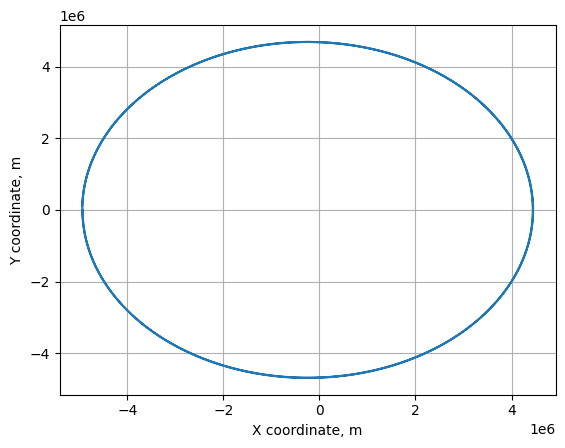

In [62]:
plt.figure(1)
plt.plot(x1, y1)
plt.grid(True)
plt.xlabel('X coordinate, m')
plt.ylabel('Y coordinate, m')
# plt.xlim(-1.6*10**11, 1.6*10**11)
plt.show()

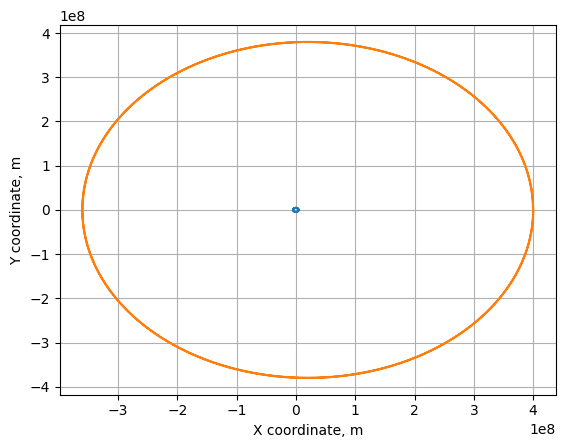

In [63]:
plt.figure(1)
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.grid(True)
plt.xlabel('X coordinate, m')
plt.ylabel('Y coordinate, m')
# plt.xlim(-1.6*10**11, 1.6*10**11)
plt.show()